# TALOS Optimization - TWO

An implementation of a hyperparameter grid search using the Talos library.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import talos

Using TensorFlow backend.
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jacobscottanthony/.local/l

### Check what hardware is available to Keras

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12047915752496629882
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8451138988614149474
physical_device_desc: "device: XLA_CPU device"
]


## Load and Split Data

In [3]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('ECL_Clean_Day.csv', 
                     infer_datetime_format=True,
                     parse_dates=['Timestamp'], 
                     index_col=['Timestamp'],
                     usecols = keep_col,
                     date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_min.dtypes
    print (df_day.shape)
    df_day.head(5)

(5031, 16)


In [4]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

In [5]:
base_train = day_train['Close'] 
base_test = day_test['Close']

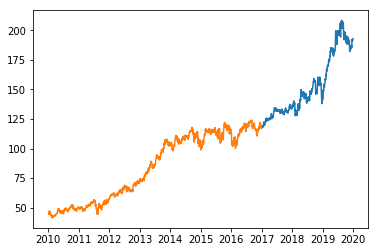

In [6]:
plt.plot(base_test)
plt.plot(base_train)
plt.show()

## Demonstrate Simple Vanilla Implementation

In [7]:
# Multi-step data preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
#raw_seq = list(base_test[:100].values)
# choose a number of time steps
n_steps_in, n_steps_out = 30, 30
# split into samples
X_train, y_train = split_sequence(base_train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(base_test.values, n_steps_in, n_steps_out) #length must be > n_in + n_out
# summarize the data
#for i in range(len(X)):
#    print(X[i], y[i])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1703, 30) (1703, 30) (695, 30) (695, 30)


In [8]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
#print (X_train.shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
#print (X_test.shape)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 43,830
Trainable params: 43,830
Non-trainable params: 0
_________________________________________________________________

Train on 1703 samples, validate on 695 samples
Epoch 1/20
1703/1703 [==============================] - 2s 1ms/step - loss: 10019.1586 - val_loss: 16243.2162
Epoch 2/20
1703/1703 [==============================] - 1s 801us/step - loss: 4184.2281 - val_loss: 22997.2938
Epoch 3/20
1703/1703 [==============================] - 1s 802us/step - loss: 1149.7130 - val_loss: 2016.9637
Epoch 4/20
1703/1703 [==============================] - 1s 789us/step - loss: 2828.2662 - val_loss: 70688.4714
Epoch 5/20
1703/1703 [

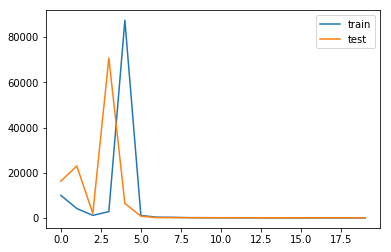

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Stacked LSTM

In [10]:
#params for grid search

p = {'LSTM_n' : [100, 200, 400],
    'LSTM_dropout' : [0, 0.1, 0.2],
    'batch_size' : [30, 60, 90, 120],
}

In [11]:
def LSTM_model(X_train, y_train, X_test, y_test, params):
    model = Sequential()                            
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu'))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='Adam', 
                  loss='mse')
    print (model.summary())
    
    #Early Stopping to avoid wasting time on bad hyperparams
    es = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

    out = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=1,
                    batch_size=params['batch_size'],
                    callbacks=[es],
                    validation_data=[X_test, y_test])
    
    return out, model

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

scan_object = talos.Scan(X_train,
                         y_train, 
                         params=p,
                         model=LSTM_model,
                         experiment_name='LSTM',
                         fraction_limit=0.5,
                         print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'LSTM_n': 200, 'batch_size': 90, 'LSTM_dropout': 0}
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
d

1192/1192 [==============================] - 2s 2ms/step - loss: 7897.5863 - val_loss: 8072.9381
Epoch 63/100
1192/1192 [==============================] - 3s 2ms/step - loss: 7896.5095 - val_loss: 8071.8384
Epoch 64/100
1192/1192 [==============================] - 3s 2ms/step - loss: 7895.4293 - val_loss: 8070.7133
Epoch 65/100
1192/1192 [==============================] - 3s 2ms/step - loss: 7894.3201 - val_loss: 8069.5869
Epoch 66/100
1192/1192 [==============================] - 3s 2ms/step - loss: 7893.2072 - val_loss: 8068.4318
Epoch 67/100
1192/1192 [==============================] - 3s 2ms/step - loss: 7892.0715 - val_loss: 8067.2591


  6%|▌         | 1/18 [03:04<52:23, 184.91s/it]

{'LSTM_n': 400, 'batch_size': 120, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
________________________________________________________________

 11%|█         | 2/18 [07:08<54:02, 202.63s/it]

{'LSTM_n': 400, 'batch_size': 120, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
________________________________________________________________

 17%|█▋        | 3/18 [09:12<44:46, 179.07s/it]

{'LSTM_n': 400, 'batch_size': 120, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________


Epoch 64/100
1192/1192 [==============================] - 5s 4ms/step - loss: 22.2883 - val_loss: 23.3776
Epoch 65/100
1192/1192 [==============================] - 5s 4ms/step - loss: 22.1940 - val_loss: 23.1266
Epoch 66/100
1192/1192 [==============================] - 5s 4ms/step - loss: 22.0562 - val_loss: 23.0420
Epoch 67/100
1192/1192 [==============================] - 5s 4ms/step - loss: 22.0881 - val_loss: 23.1485
Epoch 68/100
1192/1192 [==============================] - 5s 4ms/step - loss: 21.9483 - val_loss: 23.0951
Epoch 69/100
1192/1192 [==============================] - 5s 4ms/step - loss: 21.8024 - val_loss: 22.9416
Epoch 70/100
1192/1192 [==============================] - 5s 4ms/step - loss: 22.0205 - val_loss: 22.6167
Epoch 71/100
1192/1192 [==============================] - 5s 4ms/step - loss: 21.6203 - val_loss: 22.7293
Epoch 72/100
1192/1192 [==============================] - 5s 4ms/step - loss: 21.5094 - val_loss: 22.5359
Epoch 73/100
1192/1192 [======================

 22%|██▏       | 4/18 [17:53<1:05:39, 281.42s/it]

{'LSTM_n': 100, 'batch_size': 90, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________

 28%|██▊       | 5/18 [19:07<47:31, 219.38s/it]  

{'LSTM_n': 400, 'batch_size': 60, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________

 33%|███▎      | 6/18 [28:28<1:04:20, 321.75s/it]

{'LSTM_n': 100, 'batch_size': 90, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________

 39%|███▉      | 7/18 [30:44<48:45, 265.96s/it]  

{'LSTM_n': 400, 'batch_size': 60, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________

 44%|████▍     | 8/18 [37:05<50:04, 300.42s/it]

{'LSTM_n': 200, 'batch_size': 60, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
d

1192/1192 [==============================] - 6s 5ms/step - loss: 26.4553 - val_loss: 29.1972
Epoch 65/100
1192/1192 [==============================] - 4s 3ms/step - loss: 26.2992 - val_loss: 28.6345
Epoch 66/100
1192/1192 [==============================] - 4s 3ms/step - loss: 26.3670 - val_loss: 29.1362
Epoch 67/100
1192/1192 [==============================] - 4s 4ms/step - loss: 26.3686 - val_loss: 28.4269
Epoch 68/100
1192/1192 [==============================] - 4s 4ms/step - loss: 26.2137 - val_loss: 28.4097
Epoch 69/100
1192/1192 [==============================] - 4s 4ms/step - loss: 26.3392 - val_loss: 28.6461
Epoch 70/100
1192/1192 [==============================] - 4s 4ms/step - loss: 26.1647 - val_loss: 28.5585
Epoch 71/100
1192/1192 [==============================] - 5s 4ms/step - loss: 26.2721 - val_loss: 28.5426
Epoch 72/100
1192/1192 [==============================] - 4s 4ms/step - loss: 26.3304 - val_loss: 28.6469
Epoch 73/100
1192/1192 [==============================] - 4

 50%|█████     | 9/18 [44:32<51:41, 344.61s/it]

{'LSTM_n': 200, 'batch_size': 60, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________

 56%|█████▌    | 10/18 [46:21<36:31, 273.93s/it]

{'LSTM_n': 200, 'batch_size': 120, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
________________________________________________________________

 61%|██████    | 11/18 [47:50<25:28, 218.36s/it]

{'LSTM_n': 200, 'batch_size': 120, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________


1192/1192 [==============================] - 4s 3ms/step - loss: 50.6680 - val_loss: 47.4682
Epoch 65/100
1192/1192 [==============================] - 4s 3ms/step - loss: 51.5427 - val_loss: 42.5554
Epoch 66/100
1192/1192 [==============================] - 4s 3ms/step - loss: 44.2846 - val_loss: 47.2594
Epoch 67/100
1192/1192 [==============================] - 4s 3ms/step - loss: 42.6475 - val_loss: 39.4680
Epoch 68/100
1192/1192 [==============================] - 4s 3ms/step - loss: 37.5585 - val_loss: 38.6784
Epoch 69/100
1192/1192 [==============================] - 3s 3ms/step - loss: 35.1612 - val_loss: 36.8225
Epoch 70/100
1192/1192 [==============================] - 3s 3ms/step - loss: 36.2261 - val_loss: 39.2355
Epoch 71/100
1192/1192 [==============================] - 4s 3ms/step - loss: 38.4855 - val_loss: 42.8962
Epoch 72/100
1192/1192 [==============================] - 4s 3ms/step - loss: 35.9199 - val_loss: 35.4730
Epoch 73/100
1192/1192 [==============================] - 4

 67%|██████▋   | 12/18 [54:02<26:26, 264.48s/it]

{'LSTM_n': 100, 'batch_size': 120, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
________________________________________________________________

 72%|███████▏  | 13/18 [55:23<17:27, 209.47s/it]

{'LSTM_n': 100, 'batch_size': 30, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________

1192/1192 [==============================] - 5s 4ms/step - loss: 927.8575 - val_loss: 151.2286
Epoch 64/100
1192/1192 [==============================] - 5s 4ms/step - loss: 791.1205 - val_loss: 101.5364
Epoch 65/100
1192/1192 [==============================] - 5s 4ms/step - loss: 872.7437 - val_loss: 119.4891
Epoch 66/100
1192/1192 [==============================] - 5s 4ms/step - loss: 917.3524 - val_loss: 75.8046
Epoch 67/100
1192/1192 [==============================] - 5s 4ms/step - loss: 1048.7003 - val_loss: 78.3636
Epoch 68/100
1192/1192 [==============================] - 5s 4ms/step - loss: 843.8801 - val_loss: 60.4882
Epoch 69/100
1192/1192 [==============================] - 5s 4ms/step - loss: 825.3505 - val_loss: 107.2501
Epoch 70/100
1192/1192 [==============================] - 5s 4ms/step - loss: 960.9212 - val_loss: 90.2958
Epoch 71/100
1192/1192 [==============================] - 5s 4ms/step - loss: 783.5351 - val_loss: 106.6483
Epoch 72/100
1192/1192 [====================

 78%|███████▊  | 14/18 [1:03:14<19:11, 287.90s/it]

{'LSTM_n': 400, 'batch_size': 90, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________

 83%|████████▎ | 15/18 [1:12:29<18:24, 368.05s/it]

{'LSTM_n': 100, 'batch_size': 120, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________


1192/1192 [==============================] - 2s 1ms/step - loss: 58.2744 - val_loss: 59.6348
Epoch 64/100
1192/1192 [==============================] - 2s 1ms/step - loss: 55.5366 - val_loss: 57.3307
Epoch 65/100
1192/1192 [==============================] - 2s 1ms/step - loss: 53.9620 - val_loss: 56.0613
Epoch 66/100
1192/1192 [==============================] - 2s 1ms/step - loss: 53.1222 - val_loss: 56.0248
Epoch 67/100
1192/1192 [==============================] - 2s 1ms/step - loss: 52.5427 - val_loss: 55.5385
Epoch 68/100
1192/1192 [==============================] - 2s 1ms/step - loss: 52.1685 - val_loss: 55.2396
Epoch 69/100
1192/1192 [==============================] - 2s 1ms/step - loss: 51.7924 - val_loss: 54.9889
Epoch 70/100
1192/1192 [==============================] - 2s 1ms/step - loss: 51.6642 - val_loss: 54.6407
Epoch 71/100
1192/1192 [==============================] - 2s 1ms/step - loss: 51.3086 - val_loss: 53.3169
Epoch 72/100
1192/1192 [==============================] - 2

 89%|████████▉ | 16/18 [1:15:46<10:33, 316.56s/it]

{'LSTM_n': 200, 'batch_size': 120, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
________________________________________________________________

1192/1192 [==============================] - 2s 2ms/step - loss: 219.6733 - val_loss: 471.6683
Epoch 64/100
1192/1192 [==============================] - 2s 2ms/step - loss: 225.9546 - val_loss: 368.7301
Epoch 65/100
1192/1192 [==============================] - 2s 2ms/step - loss: 217.0810 - val_loss: 406.4689


 94%|█████████▍| 17/18 [1:18:30<04:30, 270.79s/it]

{'LSTM_n': 200, 'batch_size': 90, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________

100%|██████████| 18/18 [1:19:32<00:00, 265.13s/it]


There is a bug (link below) in the Talos library that means it sorts the columns and values from parameter dictionary incorrectly in the ```talos.Analze``` object. That is why each hyperparameter has unique values so I can easily understand the results.

[https://github.com/autonomio/talos/issues/439]

In [13]:
analyze_object = talos.Analyze(scan_object)
df = analyze_object.data
df.sort_values(by=['val_loss'])

,round_epochs,val_loss,loss,LSTM_dropout,LSTM_n,batch_size
3,100,2.106531e+01,2.030146e+01,400,120,0.0
8,100,2.864940e+01,2.605506e+01,200,60,0.0
11,100,3.358297e+01,3.066354e+01,200,120,0.0
15,100,4.870437e+01,4.565728e+01,100,120,0.0
5,59,9.014478e+01,3.850774e+02,400,60,0.1
13,93,1.508708e+02,7.260686e+02,100,30,0.1
16,65,4.064689e+02,2.170810e+02,200,120,0.2
7,44,4.691741e+02,4.158893e+02,400,60,0.2
4,29,5.363426e+02,2.677506e+02,100,90,0.1
1,46,6.770939e+02,9.969469e+02,400,120,0.2


### Results
* The top 4 results here are promising. They all achieve a val_loss and loss of < 100. Their architectures feature:
  * LSTM layer size of 200 - 400
  * No dropout on LSTMs
  * High batch sizes